O PySentimiento é uma das bibliotecas mais interessantes atualmente para análise de sentimentos e emoções com suporte a vários idiomas, incluindo português.

Ele foi criado sobre modelos BERT e RoBERTa já pré-treinados e afinados (fine-tuned) para tarefas de NLP social, como:
✅ Análise de sentimentos
✅ Análise de emoções
✅ Detecção de ódio
✅ Detecção de ironia

| Recurso                | Descrição                              |
| ---------------------- | -------------------------------------- |
| **Idiomas suportados** | en, es, it, pt, fr, ca, eu, gl         |
| **Tarefas**            | Sentiment, Emotion, Hate Speech, Irony |
| **Base**               | Modelos BERT/RoBERTa fine-tuned        |
| **Instalação**         | `pip install pysentimiento`            |


In [90]:
#Coletados Comentários
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Transformar a coluna de versões para fazer filtro melhores
from packaging.version import parse

#Para realizar paralelismo
import swifter

#Tratamentos
import emoji
import language_tool_python

#Sentimentos dos Comentários
from pysentimiento import create_analyzer

#Temas dos Comentários
import wordcloud

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

**Extração de Comentários**

In [5]:
qtd_comentarios = 10000

dados_android = []

apps = {
    "Claro": "com.nvt.cs",
    "TIM": "br.com.timbrasil.meutim",
    "Vivo": "br.com.vivo"
}

for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])

comentarios_android.to_csv("comentarios.csv", index=False)
comentarios_android.head()

,date,score,app_version,app,content
0,2025-06-03 09:29:03,5,18.8.0,Claro,ok
1,2025-06-03 09:26:10,5,18.8.0,Claro,APP bom excelente fácil de usar
2,2025-06-03 09:21:24,5,18.8.0,Claro,gostei
3,2025-06-03 09:14:17,1,18.8.0,Claro,Bom dia. Não estou conseguindo adicionar um no...
4,2025-06-03 08:47:37,1,18.8.0,Claro,eu fico doente só de lembra que tenho essa ope...


# Tratamento nos comentários

**Processamento dos Emojis**

In [7]:
def remover_emojis(texto):
    return emoji.demojize(texto, language='pt')

tool = language_tool_python.LanguageTool('pt-BR')

def ajuste_ortografico(texto):
    matches = tool.check(texto)
    return language_tool_python.utils.correct(texto, matches)

def processamento_texto(texto):
    texto_sem_emoji = remover_emojis(texto)
    texto_corrigido = ajuste_ortografico(texto_sem_emoji)
    return texto_corrigido

comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(processamento_texto)

Pandas Apply: 100%|██████████| 30000/30000 [3:42:42<00:00,  2.25it/s]   


# Análise de Sentimento

**pysentimiento**
- Biblioteca que oferece modelos baseados em BERT, fine-tunados para emoções e sentimento em português.
- Usa modelos robustos, prontos para uso.

✅ Pontos positivos:
Muito mais preciso.

Entende contexto, ironia, gírias e até alguns emojis.

Modelos modernos.

❌ Pontos negativos:
Mais pesado.

Pode exigir mais tempo de execução.

Não personalizável facilmente.

## Funções

In [10]:
analyzers = {
    "irony": create_analyzer(task="irony", lang="pt"),
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


In [7]:
#Função para realizar apenas uma análise
def analisar_sentimento(texto):
    resultado = analyzer.predict(texto)

    if resultado.output:
        saida = resultado.output[0]
    else:
        saida = None

    dados = {'output':  saida}

    for emocao, prob in resultado.probas.items():
        dados[emocao] = prob

    return pd.Series(dados)

## Análises

Meio inútil para esse caso as análises de Hate Speech e Irony, parece que os textos são muito curtos ou para comentários das Stores não são tão eficientes.

In [12]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|██████████| 30000/30000 [1:08:03<00:00,  7.35it/s]


In [ ]:
print("Data mínima da Claro: ", df[df['app']=='Claro']['date'].min())
print("Data mínima da TIM: ", df[df['app']=='TIM']['date'].min())
print("Data mínima da Vivo: ", df[df['app']=='Claro']['date'].min())
print("Data máxima da Claro: ", df[df['app']=='Claro']['date'].max())
print("Data máxima da TIM: ", df[df['app']=='TIM']['date'].max())
print("Data máxima da Vivo: ", df[df['app']=='Claro']['date'].max())

Data mínima da Claro:  2025-02-01 22:26:00
Data mínima da TIM:  2025-01-29 01:37:47
Data mínima da Vivo:  2025-02-01 22:26:00
Data máxima da Claro:  2025-06-03 09:29:03
Data máxima da TIM:  2025-06-03 09:33:35
Data máxima da Vivo:  2025-06-03 09:29:03


### Notas

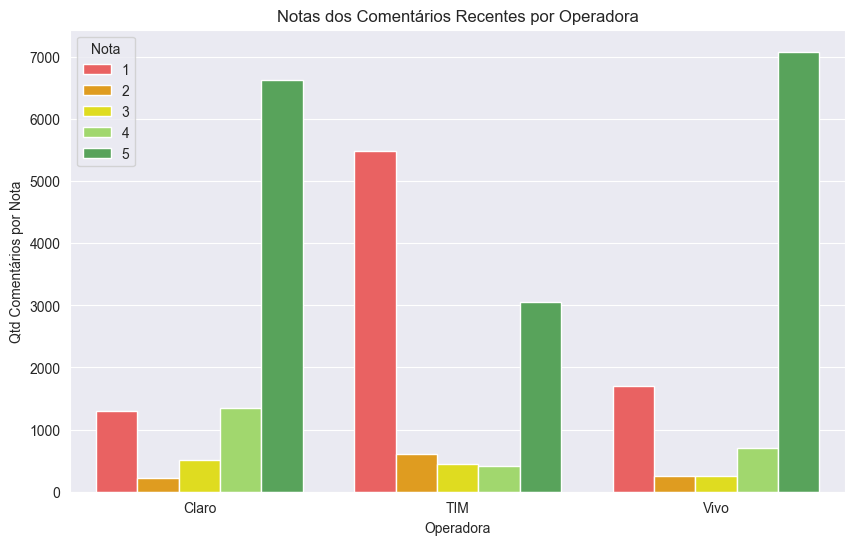

In [27]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plotar gráfico com hue simplificado
sns.countplot(
    data=df,
    x='app',
    hue='score',
    palette={1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'},
    hue_order=[1, 2, 3, 4, 5]
)

plt.title("Notas dos Comentários Recentes por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Qtd Comentários por Nota")
plt.legend(title="Nota")

plt.show()

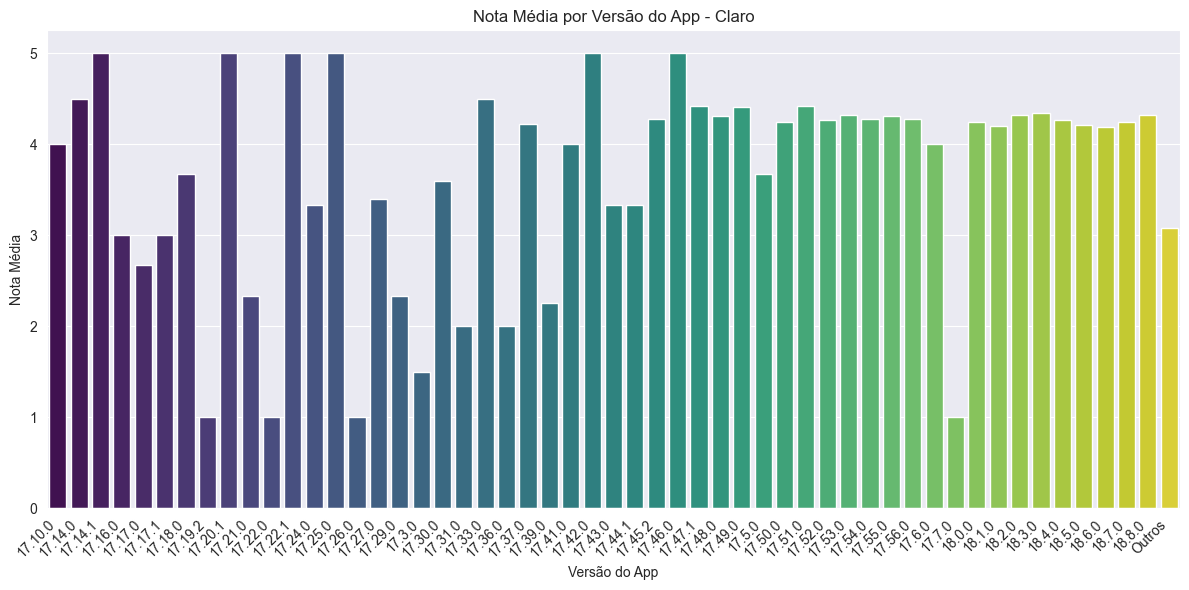

In [130]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Claro')
plt.tight_layout()
plt.show()


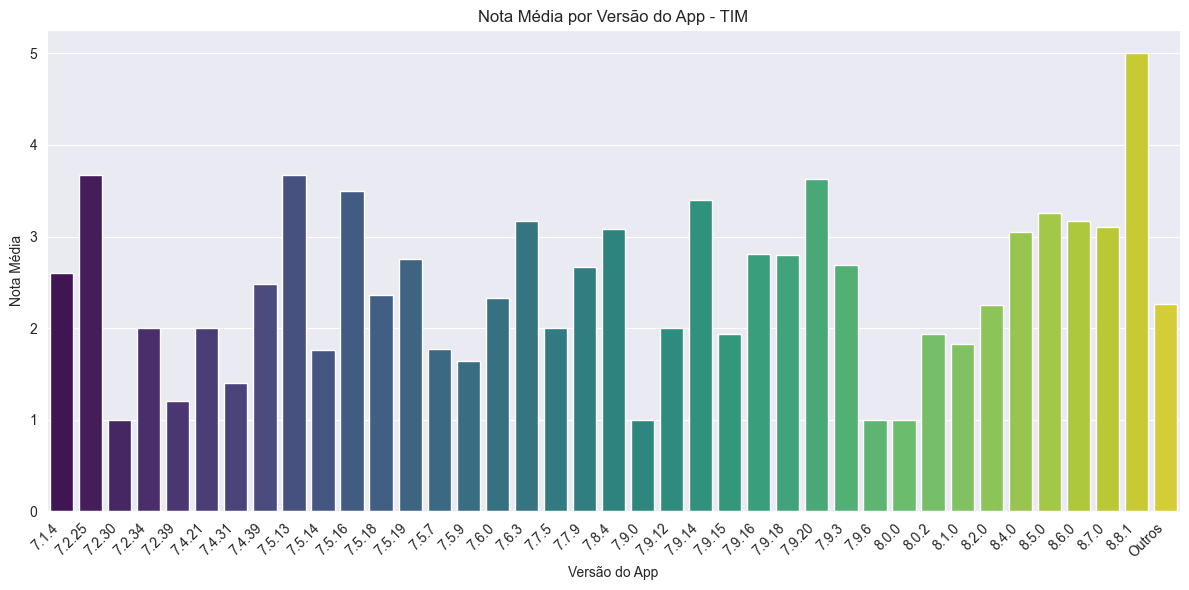

In [129]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - TIM')
plt.tight_layout()
plt.show()

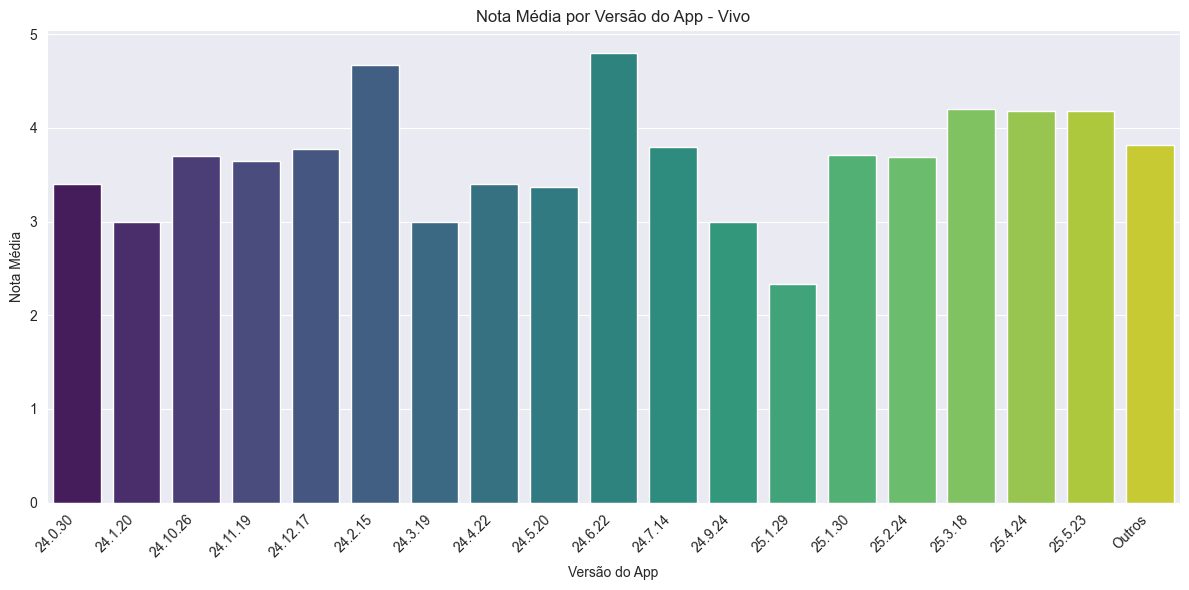

In [127]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Vivo')
plt.tight_layout()
plt.show()

### Sentimentos por Versão

#### Claro

In [ ]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,17.10.0,17.14.0,17.14.1,17.16.0,17.17.0,17.17.1,17.18.0,17.19.2,17.20.1,17.21.0,17.22.0,17.22.1,17.24.0,17.25.0,17.26.0,17.27.0,17.29.0,17.3.0,17.30.0,17.31.0,17.33.0,17.36.0,17.37.0,17.39.0,17.41.0,17.42.0,17.43.0,17.44.1,17.45.2,17.46.0,17.47.1,17.48.0,17.49.0,17.5.0,17.50.0,17.51.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,17.6.0,17.7.0,18.0.0,18.1.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,3.0,6.0,3.0,0.0,1.0,8.0,57.0,1.0,76.0,28.0,75.0,87.0,231.0,65.0,164.0,0.0,1.0,118.0,32.0,45.0,89.0,158.0,138.0,88.0,40.0,21.0,336.0
NEU,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,7.0,1.0,2.0,8.0,82.0,2.0,92.0,42.0,110.0,142.0,290.0,93.0,211.0,1.0,0.0,150.0,33.0,72.0,131.0,210.0,176.0,115.0,60.0,47.0,149.0
POS,1.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,5.0,0.0,1.0,2.0,4.0,3.0,15.0,1.0,9.0,30.0,231.0,0.0,276.0,110.0,288.0,374.0,807.0,217.0,570.0,0.0,0.0,391.0,83.0,209.0,335.0,577.0,476.0,310.0,160.0,96.0,255.0


In [ ]:
frequencias = df[df['app'] == 'Claro']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Claro']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,17.49.0,17.50.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,18.0.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,Outros
sentiment_output,,,,,,,,,,,,,,,
NEG,57,76,75,87,231,65,164,118,45,89,158,138,88,40,173
NEU,82,92,110,142,290,93,211,150,72,131,210,176,115,60,176
POS,231,276,288,374,807,217,570,391,209,335,577,476,310,160,397


#### TIM

In [93]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,7.1.4,7.2.25,7.2.30,7.2.34,7.2.39,7.4.21,7.4.31,7.4.39,7.5.13,7.5.14,7.5.16,7.5.18,7.5.19,7.5.7,7.5.9,7.6.0,7.6.3,7.7.5,7.7.9,7.8.4,7.9.0,7.9.12,7.9.14,7.9.15,7.9.16,7.9.18,7.9.20,7.9.3,7.9.6,8.0.0,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,3.0,1.0,1.0,8.0,5.0,5.0,14.0,14.0,2.0,16.0,2.0,10.0,9.0,6.0,31.0,10.0,4.0,3.0,4.0,5.0,1.0,0.0,2.0,11.0,17.0,37.0,134.0,29.0,1.0,1.0,1330.0,659.0,1193.0,354.0,220.0,602.0,185.0,1.0,1165.0
NEU,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0,1.0,2.0,1.0,1.0,3.0,0.0,7.0,2.0,6.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,8.0,6.0,73.0,9.0,0.0,0.0,194.0,113.0,255.0,123.0,94.0,264.0,79.0,0.0,262.0
POS,2.0,1.0,0.0,0.0,0.0,3.0,0.0,4.0,3.0,3.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0,0.0,0.0,6.0,0.0,0.0,3.0,3.0,6.0,21.0,189.0,19.0,0.0,0.0,205.0,96.0,324.0,258.0,210.0,525.0,134.0,0.0,353.0


In [107]:
frequencias = df[df['app'] == 'TIM']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'TIM']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,7.9.20,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,Outros
sentiment_output,,,,,,,,,
NEG,134,1330,659,1193,354,220,602,185,417
NEU,73,194,113,255,123,94,264,79,89
POS,189,205,96,324,258,210,525,134,142


#### Vivo

In [115]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,24.0.30,24.1.20,24.10.26,24.11.19,24.12.17,24.2.15,24.3.19,24.4.22,24.5.20,24.6.22,24.7.14,24.9.24,25.1.29,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,
NEG,1.0,2.0,4.0,8.0,7.0,0.0,3.0,0.0,5.0,0.0,4.0,6.0,2.0,23.0,30.0,510.0,689.0,414.0,392.0
NEU,2.0,0.0,1.0,8.0,7.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,17.0,18.0,589.0,762.0,453.0,263.0
POS,2.0,0.0,5.0,4.0,13.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,0.0,37.0,43.0,1498.0,2166.0,1266.0,711.0


In [113]:
frequencias = df[df['app'] == 'Vivo']['app_version'].value_counts()

limiar = 50
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Vivo']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,
NEG,23,30,510,689,414,87
NEU,17,18,589,762,453,50
POS,37,43,1498,2166,1266,91


### Sentimentos

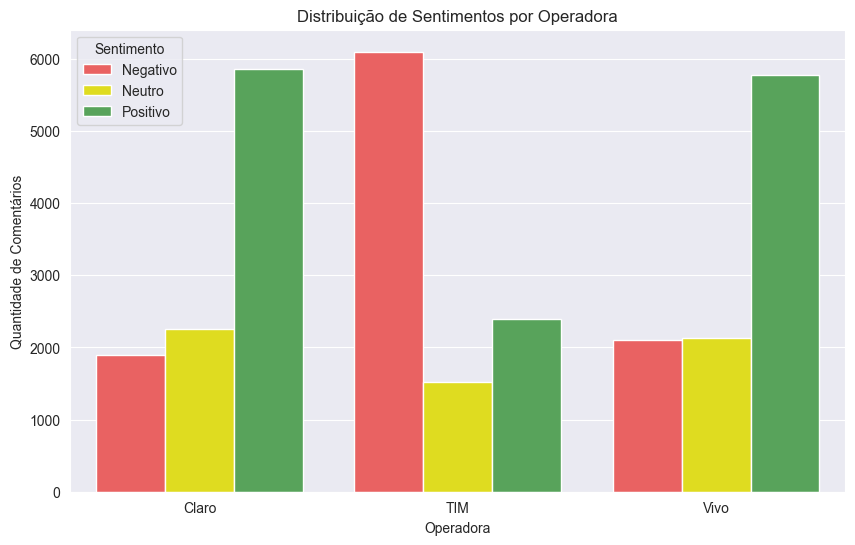

In [150]:
def map_sentiment(sent):
    if sent in ['NEG', 'negativo']:
        return 'Negativo'
    elif sent in ['NEU', 'neutro']:
        return 'Neutro'
    elif sent in ['POS', 'positivo']:
        return 'Positivo'
    else:
        return 'Outro'

df['sentimento_simplificado'] = df['sentiment_output'].apply(map_sentiment)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()


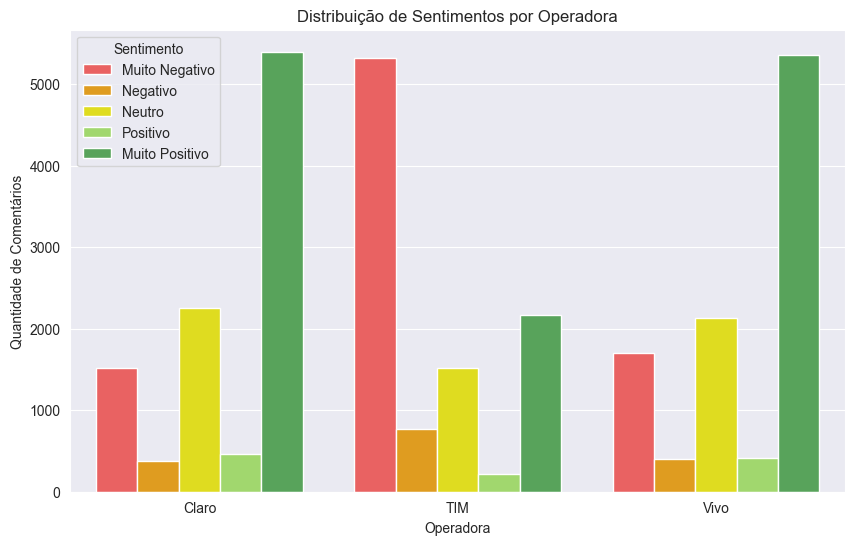

In [149]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.8:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.8:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        return "Neutro"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

In [123]:
values_claro = df[df['app'] == 'Claro'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_tim = df[df['app'] == 'TIM'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_vivo = df[df['app'] == 'Vivo'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confiança', 'Confusão', 'Neutro']

# Valores de exemplo para cada operadora
values_vivo = values_vivo
values_tim = values_tim
values_claro = values_claro

# Criar subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Gráfico Vivo
fig.add_trace(go.Scatterpolar(
    r=values_vivo,  # Não fechando a linha
    theta=categories,
    fill='toself',
    name='Vivo',
    line=dict(color='royalblue'),
    opacity=0.7
), row=1, col=1)

# Gráfico TIM
fig.add_trace(go.Scatterpolar(
    r=values_tim,
    theta=categories,
    fill='toself',
    name='TIM',
    line=dict(color='firebrick'),
    opacity=0.7
), row=1, col=2)

# Gráfico Claro
fig.add_trace(go.Scatterpolar(
    r=values_claro,
    theta=categories,
    fill='toself',
    name='Claro',
    line=dict(color='darkgreen'),
    opacity=0.7
), row=1, col=3)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="Distribuição de Emoções por Operadora",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False))
)


# Ajuste do posicionamento dos títulos: mais para cima
fig.add_annotation(dict(font=dict(size=16),
                        x=0.13,
                        y=1.1,
                        showarrow=False,
                        text="Vivo",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.1,
                        showarrow=False,
                        text="TIM",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.87,
                        y=1.1,
                        showarrow=False,
                        text="Claro",
                        xref="paper",
                        yref="paper"))

fig.show()


# Classificação de Temas

passar todo o tratamento no NLTK ou outras libs para fazer uma word cloud e saber os principais temas aboradas nos comentários


# Próximas Etapas a serem feitas

### Tratamentos
- **OK** - Extração 10k comentários
- **OK** - Apenas comentários de Android
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Ortográfia
- **OK** - Emoji
- **NOTOK** - Abreviações e gírias - Muito complicado para fazer

### Análise Exploratória
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Sentimento Geral por versão
- **OK** - Volume geral por versão do app
- **OK** - Nota média dos comentários por versão
- **NOTOK** - Ironia, classificou tudo como ironia
- **OK** - Os sentimentos como neutros tem a classificação entre 0,3 e 1,0. Não teria como classficar em positivos ou negativos
- **OK** - Separação de positivos e negativos fortes e fracos
- **WIP** - Periodicidade dos comentários para realizar uma análise ao decorrer do tempo de sentimento

### Análise Exploratória
- **WIP** - classificar os temas gerais
- **WIP** - classificar os temas de neutros
- **WIP** - scatterplot vendo o volume de temas
- **WIP** - mapa de wordcloud